# Single Object Localisation

In [1]:
import numpy as np

from tqdm import tqdm

## Data loading

NOTE: does not work now, because the dataset is not available anymore at the original location.

In [8]:
# import requests, zipfile

# # Download dataset
# dataset_link = "https://www.dropbox.com/scl/fi/ha6f9n5rcae6h79dhdykb/pikachu.zip?rlkey=b1z9xqub0z4acglomt9r983q0&dl=1"
# dataset_file_path = "dataset.zip"
# download_response = requests.get(dataset_link)

# with open(dataset_file_path, "wb") as downloaded_file:
#     downloaded_file.write(download_response.content)

# with zipfile.ZipFile(dataset_file_path, "r") as unzipped_file:
#     unzipped_file.extractall(".")

## Data preprocessing

In [9]:
from PIL import Image

import json
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import os


def read_images(file_path: str, target_size: tuple = (64, 64)) -> tuple:
    files = os.listdir(file_path + "/images")

    images = []
    labels = []
    labels_json = json.load(open(file_path + "/annotations.json"))

    for image_file in tqdm(files):
        image = Image.open(os.path.join(file_path + "/images", image_file))
        image = image.convert("RGB")
        image = image.resize(target_size)
        image = np.array(image)
        images.append(image)

        idx = image_file.split("_")[1].split(".")[0]
        loc = np.array(labels_json[f"data_{idx}"]["loc"])
        labels.append(loc)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels


def plot_loc(idx: int, images: np.ndarray, labels: np.ndarray):
    img = images[idx]
    loc = labels[idx]
    plot_sample(img, loc)


def plot_sample(image: np.ndarray, loc: np.ndarray, true_loc: np.ndarray = None):
    ww, hh, __ = image.shape

    x1, y1, x2, y2 = loc * np.array([ww, hh, ww, hh])
    loc_ww = x2 - x1
    loc_hh = y2 - y1

    plt.imshow(image)
    ax = plt.gca()
    rect = patches.Rectangle(
        xy=(x1, y1),
        width=loc_ww,
        height=loc_hh,
        linewidth=2,
        edgecolor="r",
        facecolor="none",
    )
    ax.add_patch(rect)
    plt.show()

In [10]:
# Read the dataset
train_dir, val_dir = "train", "val"

train_images, train_labels = read_images(train_dir)
val_images, val_labels = read_images(val_dir)

# Normalize the images
train_images = train_images / 255.0
val_images = val_images / 255.0

# Reshape the images to (B, C, H, W)
train_images_reshaped = train_images.transpose(0, 3, 1, 2)[:, None, :, :, :]
val_images_reshaped = val_images.transpose(0, 3, 1, 2)[:, None, :, :, :]

# Reshape labels to (4, 1)
train_labels_reshaped = train_labels[:, :, None]
val_labels_reshaped = val_labels[:, :, None]

  0%|          | 0/900 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 239.26it/s]


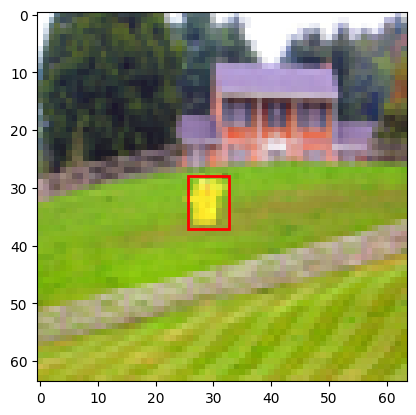

In [11]:
plot_loc(120, train_images, train_labels)

## Model and training

In [12]:
class CNN(Network):
    def __init__(self, in_channels: int, num_classes: int):
        super().__init__(
            [
                Conv2d(in_channels, num_filters=1, kernel_size=3),
                ReLU(),
                Flatten((1, 1, 62, 62)),
                Linear(1 * 1 * 62 * 62, 2048),
                ReLU(),
                Linear(2048, num_classes),
                Sigmoid(),
            ],
            SSE(),
            jaccard_coefficient,
        )

In [13]:
model = CNN(3, 4)
model.train(
    train_images_reshaped,
    train_labels_reshaped,
    val_x=val_images_reshaped,
    val_y=val_labels_reshaped,
    epochs=5,
    lr=0.05,
)

Epoch 1/5


100%|██████████| 900/900 [00:53<00:00, 16.80it/s, loss=0.0144]
C:\Users\danielpancake\AppData\Local\Temp\ipykernel_12092\498944332.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intersection = float(max(0, x1 - x0) * max(0, y1 - y0))
C:\Users\danielpancake\AppData\Local\Temp\ipykernel_12092\498944332.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  union = float(bbox_a_ww * bbox_a_hh + bbox_b_ww * bbox_b_hh - intersection)


Evaluating... Validation score: 48.01334%
Epoch 2/5


100%|██████████| 900/900 [00:48<00:00, 18.68it/s, loss=0.00453]


Evaluating... Validation score: 52.71195%
Epoch 3/5


100%|██████████| 900/900 [00:48<00:00, 18.51it/s, loss=0.00303]


Evaluating... Validation score: 54.99905%
Epoch 4/5


100%|██████████| 900/900 [00:47<00:00, 18.82it/s, loss=0.00231]


Evaluating... Validation score: 56.43941%
Epoch 5/5


100%|██████████| 900/900 [00:46<00:00, 19.29it/s, loss=0.00187]


Evaluating... Validation score: 57.09971%


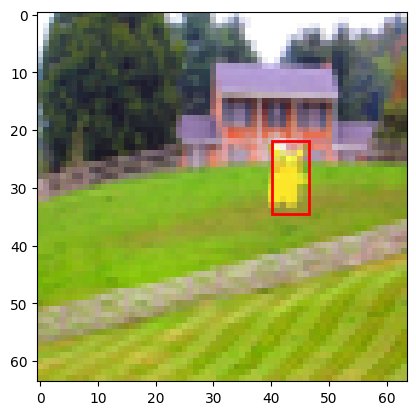

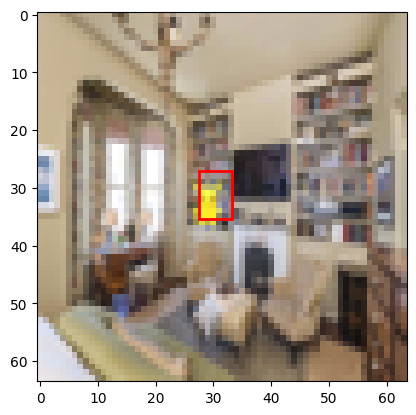

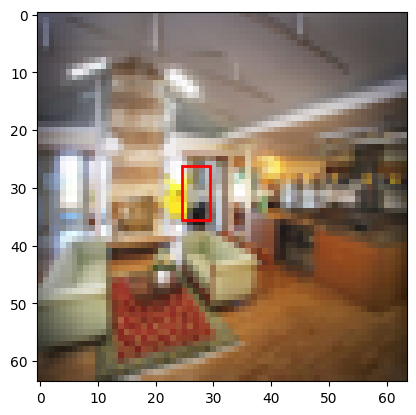

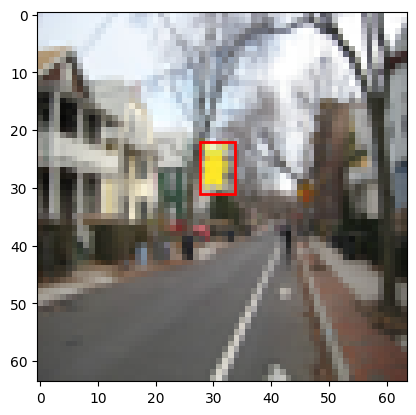

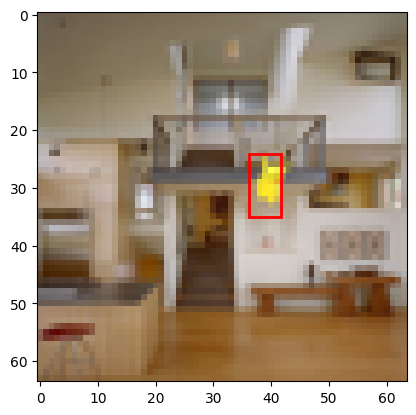

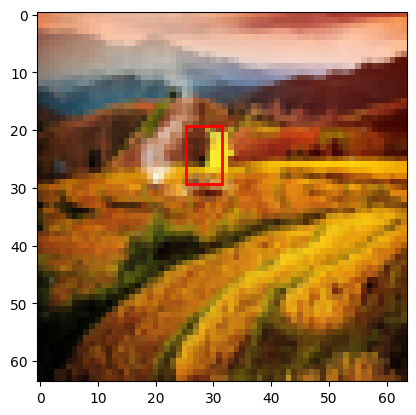

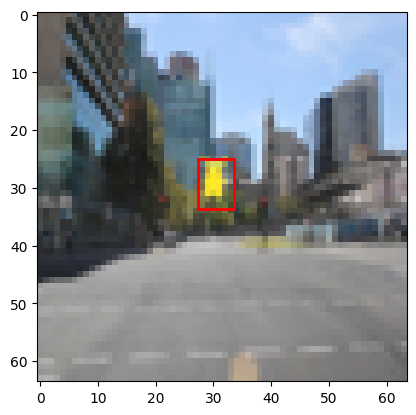

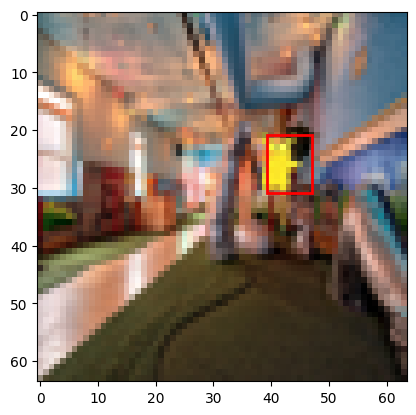

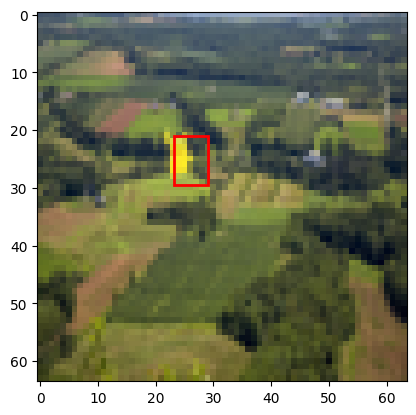

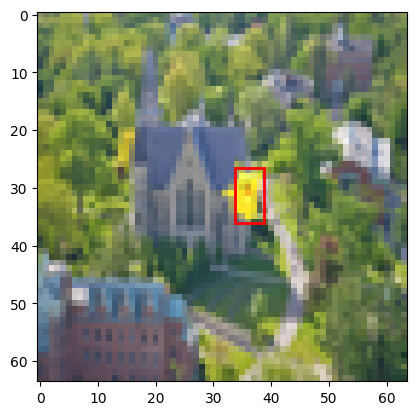

In [14]:
for idx in np.random.randint(0, len(train_images), 10):
    plot_sample(
        train_images[idx],
        model.forward(train_images_reshaped[idx]).flatten(),
    )